In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
import scipy.stats as st
from astropy.stats import LombScargle
from astropy.io import fits
sns.set_context('notebook')
plt.style.use('seaborn')
style = {
    'figure.figsize': (12, 8),
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 14,
}
rcParams.update(style)
import pymc3 as pm

In [3]:
lc = pd.read_table('data/kplr007107778_kasoc-ts_slc_v1.dat', sep='\s+', comment='#', names=['time', 'flux', 'flux_error'], dtype='f8')
psd = pd.read_table('data/kplr007107778_kasoc-psd_slc_v1.pow', sep='\s+', comment='#', names=['freq', 'power'], dtype='f8')

In [4]:
t = lc['time']
f = lc['flux']
ferr = lc['flux_error']

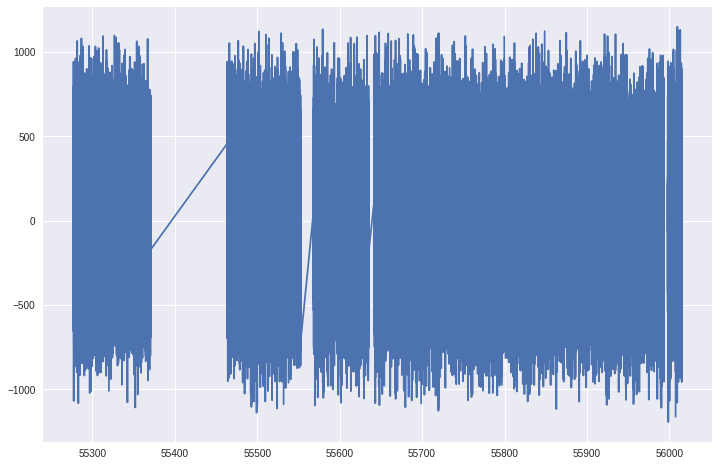

In [5]:
plt.plot(t, f);

In [59]:
freq, power = LombScargle(t, f, dy=ferr, fit_mean=False, center_data=False, normalization='psd').autopower()

In [6]:
mask = psd['freq'] > 12
full_freq = psd['freq'][mask]
full_power = psd['power'][mask]

In [7]:
freq = np.linspace(min(full_freq), max(full_freq), 1000)
power = np.interp(freq, full_freq, full_power)
# freq = full_freq
# power = full_power

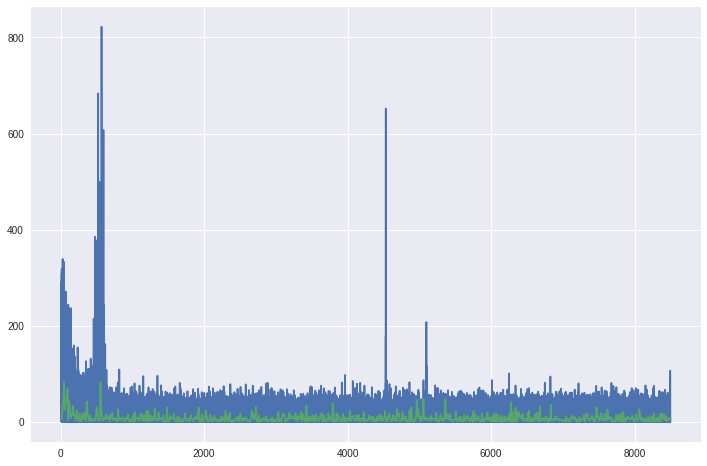

In [8]:
plt.plot(full_freq, full_power)
plt.plot(freq, power);

In [ ]:
v_nyq = 8496.36
with pm.Model() as model:
    W = pm.Normal('W', mu=0, sd=10)
    R_v = (pm.math.sin( np.pi * freq / (2 * v_nyq)) / ((np.pi * freq) / (2 * v_nyq)))**2
#     R_v = 1
    k=3
    a = pm.Normal('a', mu=0, sd=10, shape=(k,1))
    b = pm.Normal('b', mu=0, sd=10, shape=(k,1))
    
    harv = pm.math.sum(2 * pm.math.sqrt(2) / np.pi * (a**2 / b) / (1 + (freq / b)**4), axis=0)
    
    H0 = pm.Normal('H0', mu=0, sd=10)
    v_max = pm.Bound(pm.Normal, lower=0)('v_max', mu=0, sd=10)
    s = pm.HalfCauchy('s', 10)
    
    e = pm.HalfCauchy('e', 10)
    mu = W + R_v * (harv + H0 * pm.math.exp(-(f - v_max)**2) / (2 * s**2))
    y = pm.Normal('obs', mu, sd=e, observed=power)

In [ ]:
with model:
    trace = pm.sample(1000, tune=500)

In [ ]:
pm.traceplot(trace);

In [56]:
ppc = pm.sample_ppc(trace, 1000, model)
post = ppc['obs'].mean(axis=0)

100%|██████████| 1000/1000 [00:01<00:00, 820.03it/s]
